In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cluster_data.csv',encoding = 'utf-8')

In [ ]:
df

# 1. 데이터 준비 및 전처리

In [3]:
label_encoder = LabelEncoder()
df['고객상태'] = label_encoder.fit_transform(df['고객상태'])

quantitative_features = ['거래활동기간', '거래 연속성 비율', '총거래건수', '총거래금액', '월평균 거래건수']
qualitative_features = ['거래지역다양성지수', '업종다양성지수', '출장여부', '고객상태']

weights = {
    '거래활동기간': 1.5, '거래 연속성 비율': 1.5, '총거래건수': 2.0, '총거래금액': 1.0,
    '월평균 거래건수': 2.0, '거래지역다양성지수': 1.0, '업종다양성지수': 1.2, 
    '출장여부': 1.2, '고객상태': 1.3
}
for col, weight in weights.items():
    df[col] *= weight

# 2. pca차원축소

## 1 - x

In [ ]:
pca_quantitative = PCA(n_components=2)
quant_pca = pca_quantitative.fit_transform(df[quantitative_features])

pca_qualitative = PCA(n_components=2)
qual_pca = pca_qualitative.fit_transform(df[qualitative_features])

df['혼합정보_1'] = quant_pca[:, 0] + qual_pca[:, 0]
df['혼합정보_2'] = quant_pca[:, 1] + qual_pca[:, 1]

## 2

In [4]:
scaler_quantitative = StandardScaler()
scaled_quantitative = scaler_quantitative.fit_transform(df[quantitative_features])

scaler_qualitative = StandardScaler()
scaled_qualitative = scaler_qualitative.fit_transform(df[qualitative_features])

pca_quantitative = PCA(n_components=2)
quant_pca = pca_quantitative.fit_transform(scaled_quantitative)

pca_qualitative = PCA(n_components=2)
qual_pca = pca_qualitative.fit_transform(scaled_qualitative)

df['혼합정보_1'] = quant_pca[:, 0] + qual_pca[:, 0]
df['혼합정보_2'] = quant_pca[:, 1] + qual_pca[:, 1]

# 3. 군집화 및 업종리스트

In [5]:
kmeans_30 = KMeans(n_clusters=30, random_state=42)
df['군집'] = kmeans_30.fit_predict(df[['혼합정보_1', '혼합정보_2']])

top_n = 10
업종_리스트 = (
    df.groupby('군집')['업종_그룹']
    .apply(lambda x: x.value_counts().head(top_n).index.tolist())
    .reset_index(name='업종_리스트')
)
df = df.merge(업종_리스트, on='군집', how='left')

군집 수 9 완료
군집 수 10 완료
군집 수 11 완료
군집 수 12 완료
군집 수 13 완료
군집 수 14 완료
군집 수 15 완료
군집 수 16 완료
군집 수 17 완료
군집 수 18 완료
군집 수 19 완료
군집 수 20 완료


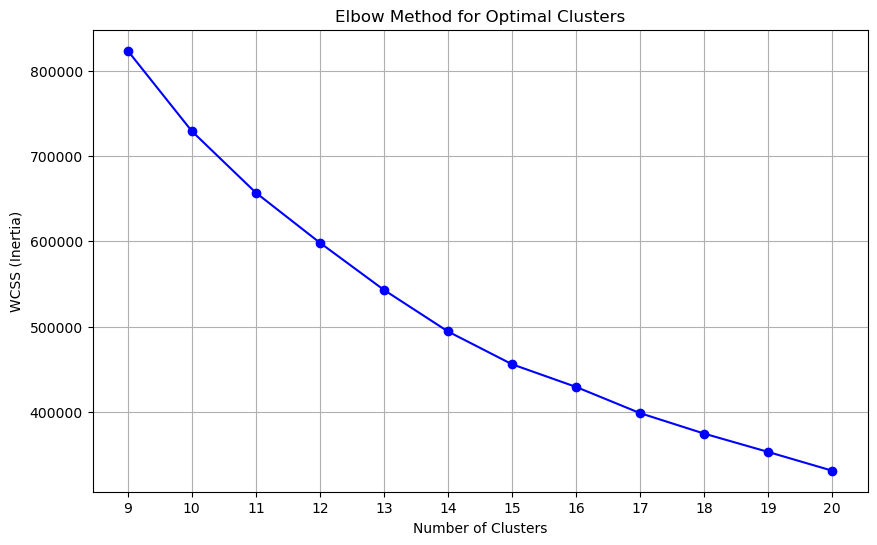

In [6]:
range_n_clusters = range(9, 21)  

inertia = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df[['혼합정보_1', '혼합정보_2']])
    inertia.append(kmeans.inertia_)
    print(f"군집 수 {n_clusters} 완료")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

# 4. 군집 축소 (k=15) 및 자카드 유사도 계산

In [7]:
kmeans_15 = KMeans(n_clusters=14, random_state=42)
df['최종군집'] = kmeans_15.fit_predict(df[['혼합정보_1', '혼합정보_2']])

def jaccard_similarity(cluster1, cluster2):
    intersection = len(set(cluster1) & set(cluster2))
    union = len(set(cluster1) | set(cluster2))
    return intersection / union

mlb = MultiLabelBinarizer()
binarized_terms = mlb.fit_transform(업종_리스트['업종_리스트'])

jaccard_matrix = pairwise_distances(binarized_terms, metric=jaccard_similarity)

In [32]:
jaccard_df = pd.DataFrame(jaccard_matrix, 
                          index=업종_리스트['업종_리스트'], 
                          columns=업종_리스트['업종_리스트'])

result = []
for idx, row in enumerate(jaccard_matrix):
    current_industry = 업종_리스트['업종_리스트'][idx]  
    cluster_info = df.loc[df['업종_리스트'].isin([current_industry]), '최종군집'].values
    if len(cluster_info) > 0: 
        cluster = cluster_info[0]
    else:
        cluster = None 
    
    sorted_indices = row.argsort()[::-1][1:6]
    for similar_idx in sorted_indices:
        result.append({
            '업종': current_industry,
            '클러스터': cluster,
            '유사한 업종': 업종_리스트['업종_리스트'][similar_idx],
            '유사도': row[similar_idx]
        })

similarity_result_df = pd.DataFrame(result)
similarity_result_df.sort_values(by='유사도', ascending=False, inplace=True)

In [33]:
similarity_result_df

,업종,클러스터,유사한 업종,유사도
0,"[음식점, 온라인쇼핑, 생활, 의료/건강, 식료품, 스포츠/레저, 통신, 보험, 자...",3,"[음식점, 생활, 기타 서비스업, 보험, 온라인쇼핑, 의료/건강, 대중교통, 주유소...",1.0
94,"[생활, 음식점, 기타 서비스업, 온라인쇼핑, 의료/건강, 식료품, 주유소, 보험,...",13,"[음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 주유소, 보험, 대중교통, 통신...",1.0
96,"[음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 주유소, 보험, 통신, 스포츠/...",3,"[음식점, 생활, 온라인쇼핑, 의료/건강, 기타 서비스업, 통신, 식료품, 주유소,...",1.0
97,"[음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 주유소, 보험, 통신, 스포츠/...",3,"[생활, 음식점, 의료/건강, 식료품, 온라인쇼핑, 주유소, 스포츠/레저, 기타 서...",1.0
98,"[음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 주유소, 보험, 통신, 스포츠/...",3,"[음식점, 생활, 온라인쇼핑, 의료/건강, 기타 서비스업, 식료품, 대중교통, 주유...",1.0
...,...,...,...,...
50,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡...",6,"[음식점, 생활, 기타 서비스업, 보험, 온라인쇼핑, 의료/건강, 대중교통, 주유소...",1.0
51,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡...",6,"[음식점, 생활, 온라인쇼핑, 의료/건강, 기타 서비스업, 통신, 식료품, 주유소,...",1.0
52,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡...",6,"[생활, 음식점, 의료/건강, 식료품, 온라인쇼핑, 주유소, 스포츠/레저, 기타 서...",1.0
53,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡...",6,"[음식점, 생활, 온라인쇼핑, 의료/건강, 기타 서비스업, 식료품, 대중교통, 주유...",1.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834440 entries, 0 to 834439
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   고객ID         834440 non-null  int64  
 1   최초거래년월       834440 non-null  int64  
 2   최종거래년월       834440 non-null  int64  
 3   거래활동기간       834440 non-null  float64
 4   거래 연속성 비율    834440 non-null  float64
 5   거래 밀도 지수     834440 non-null  float64
 6   비활성화 기간 비율   834440 non-null  float64
 7   총 거래 공백 개월수  834440 non-null  int64  
 8   월평균 거래금액     834440 non-null  float64
 9   월평균 거래건수     834440 non-null  float64
 10  업종다양성지수      834440 non-null  float64
 11  신규유입고객       834440 non-null  int64  
 12  거래지역다양성지수    834440 non-null  float64
 13  총거래금액        834440 non-null  float64
 14  총거래건수        834440 non-null  float64
 15  승인건수점수       834440 non-null  int64  
 16  승인금액점수       834440 non-null  int64  
 17  승인점수         834440 non-null  int64  
 18  고객상태         834440 non-

In [39]:
df2 = df.copy()
df2 = df2[['고객ID','거래활동기간', '거래 연속성 비율', '총거래건수', '총거래금액', '월평균 거래건수','거래지역다양성지수', '업종다양성지수', '출장여부', '고객상태','군집','최종군집','업종_리스트']]

df2.head(20)

,고객ID,거래활동기간,거래 연속성 비율,총거래건수,총거래금액,월평균 거래건수,거래지역다양성지수,업종다양성지수,출장여부,고객상태,군집,최종군집,업종_리스트
0,2002967708,1.5,150.0,10.0,210000.0,10.0,2.0,2.4,0.0,1.3,21,5,"[생활, 음식점, 기타 서비스업, 식료품, 온라인쇼핑, 의료/건강, 주유소, 보험,..."
1,2004066711,1.5,150.0,5.0,40000.0,5.0,1.0,1.2,0.0,1.3,21,5,"[생활, 음식점, 기타 서비스업, 식료품, 온라인쇼핑, 의료/건강, 주유소, 보험,..."
2,2004166649,1.5,150.0,30.0,220000.0,30.0,3.0,7.2,1.2,1.3,6,6,"[생활, 음식점, 온라인쇼핑, 의료/건강, 식료품, 기타 서비스업, 주유소, 대중교..."
3,2004326617,1.5,150.0,5.0,10000.0,5.0,1.0,1.2,1.2,1.3,10,6,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡..."
4,2004432929,1.5,150.0,10.0,460000.0,10.0,2.0,2.4,1.2,1.3,10,6,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡..."
5,2004485471,1.5,150.0,5.0,10000.0,5.0,1.0,1.2,1.2,1.3,10,6,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡..."
6,2004762122,1.5,150.0,30.0,360000.0,30.0,2.0,6.0,0.0,1.3,21,5,"[생활, 음식점, 기타 서비스업, 식료품, 온라인쇼핑, 의료/건강, 주유소, 보험,..."
7,2004878876,1.5,150.0,15.0,130000.0,15.0,1.0,2.4,1.2,1.3,10,6,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡..."
8,2005112490,1.5,150.0,5.0,20000.0,5.0,1.0,1.2,1.2,1.3,10,6,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡..."
9,2005192642,1.5,150.0,5.0,10000.0,5.0,1.0,1.2,1.2,1.3,10,6,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 스포츠/레저, 뷰티/헤어/잡..."


# 5. 협업 필터링 및 추천 시스템 구현

## 1

In [ ]:
top_n = 10
cluster_recommendations = defaultdict(list)

for cluster_id in df['최종군집'].unique():
    cluster_data = df[df['최종군집'] == cluster_id]
    if '업종_그룹' in df.columns:  
        value_counts = cluster_data['업종_그룹'].value_counts()
        
        weighted_scores = {
            index: (rank + 1) * value_counts[index]
            for rank, index in enumerate(value_counts.head(top_n).index)
        }
        
        sorted_recommendations = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
        cluster_recommendations[cluster_id] = [item[0] for item in sorted_recommendations]
    else:
        raise KeyError("'업종_그룹' 컬럼이 데이터프레임에 없습니다. 확인해 주세요.")

print("각 군집의 추천 업종_그룹:")
for cluster_id, recommendations in cluster_recommendations.items():
    print(f"군집 {cluster_id}: {recommendations}")

In [ ]:
top_n = 10
cluster_recommendations = defaultdict(list)

for cluster_id in df['최종군집'].unique():
    cluster_data = df[df['최종군집'] == cluster_id]
    if '업종_그룹' in df.columns:
        value_counts = cluster_data['업종_그룹'].value_counts()
        weighted_scores = {
            index: (rank + 1) * value_counts[index]
            for rank, index in enumerate(value_counts.head(top_n).index)
        }
        sorted_recommendations = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
        cluster_recommendations[cluster_id] = [item[0] for item in sorted_recommendations]
    else:
        raise KeyError("'업종_그룹' 컬럼이 데이터프레임에 없습니다. 확인해 주세요.")

def prepare_knn_model(df, features, n_neighbors=10):
    """Nearest Neighbors 모델 생성"""
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn_model.fit(df[features])
    return knn_model

def generate_knn_recommendations(knn_model, df, target_customer_idx, features, cluster_recommendations, top_n=10):
    """KNN을 활용하여 고객별 추천 생성"""
    target_vector = df.iloc[target_customer_idx][features].values.reshape(1, -1)
    customer_cluster = df.iloc[target_customer_idx]['최종군집']
    cluster_items = cluster_recommendations.get(customer_cluster, [])

    distances, indices = knn_model.kneighbors(target_vector)

    similar_customers = df.iloc[indices[0]]
    content_items = similar_customers['업종_그룹'].value_counts().index[:top_n].tolist()

    combined_items = list(set(cluster_items + content_items))[:top_n]
    return combined_items

print("KNN 모델 준비 시작...")
knn_model = prepare_knn_model(df, features=['혼합정보_1', '혼합정보_2'], n_neighbors=20)
print("KNN 모델 준비 완료.")

recommendations_per_customer = defaultdict(list)

print("추천 시스템 실행 시작...")
for idx in tqdm(range(len(df)), desc="추천 진행률"):
    recommendations_per_customer[df.iloc[idx]['고객ID']] = generate_knn_recommendations(
        knn_model,
        df,
        target_customer_idx=idx,
        features=['혼합정보_1', '혼합정보_2'],
        cluster_recommendations=cluster_recommendations,
        top_n=10
    )
print("추천 시스템 실행 완료.")

In [23]:
sample_size = 100000
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

top_n = 10
cluster_recommendations = defaultdict(list)

for cluster_id in df_sample['최종군집'].unique():
    cluster_data = df_sample[df_sample['최종군집'] == cluster_id]
    if '업종_그룹' in df_sample.columns:
        value_counts = cluster_data['업종_그룹'].value_counts()
        weighted_scores = {
            index: (rank + 1) * value_counts[index]
            for rank, index in enumerate(value_counts.head(top_n).index)
        }
        sorted_recommendations = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
        cluster_recommendations[cluster_id] = [item[0] for item in sorted_recommendations]
    else:
        raise KeyError("'업종_그룹' 컬럼이 데이터프레임에 없습니다. 확인해 주세요.")

def prepare_knn_model(df, features, n_neighbors=10):
    """Nearest Neighbors 모델 생성"""
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn_model.fit(df[features])
    return knn_model

def generate_knn_recommendations(knn_model, df, target_customer_idx, features, cluster_recommendations, top_n=10):
    """KNN을 활용하여 고객별 추천 생성"""
    # 대상 고객의 벡터
    target_vector = df.iloc[target_customer_idx][features].values.reshape(1, -1)
    customer_cluster = df.iloc[target_customer_idx]['최종군집']
    cluster_items = cluster_recommendations.get(customer_cluster, [])

    distances, indices = knn_model.kneighbors(target_vector)

    similar_customers = df.iloc[indices[0]]
    content_items = similar_customers['업종_그룹'].value_counts().index[:top_n].tolist()

    combined_items = list(set(cluster_items + content_items))[:top_n]
    return combined_items

print("KNN 모델 준비 시작...")
knn_model = prepare_knn_model(df_sample, features=['혼합정보_1', '혼합정보_2'], n_neighbors=20)
print("KNN 모델 준비 완료.")

recommendations_per_customer = defaultdict(list)

print("추천 시스템 실행 시작...")
for idx in tqdm(range(len(df_sample)), desc="추천 진행률"):
    recommendations_per_customer[df_sample.iloc[idx]['고객ID']] = generate_knn_recommendations(
        knn_model,
        df_sample,
        target_customer_idx=idx,
        features=['혼합정보_1', '혼합정보_2'],
        cluster_recommendations=cluster_recommendations,
        top_n=10
    )
print("추천 시스템 실행 완료.")

KNN 모델 준비 시작...
KNN 모델 준비 완료.
추천 시스템 실행 시작...


추천 진행률: 100%|██████████| 100000/100000 [15:37<00:00, 106.71it/s]

추천 시스템 실행 완료.


# 6. 외부데이터셋에 추천시스템 적용

In [ ]:
external_df = pd.read_csv("외부데이터.csv")  

column_mapping = {
    '고객ID': '발급회원번호',
    '업종_그룹': '최상위카드등급코드', 
    '최종군집': '군집'  
}

external_df = external_df.rename(columns=column_mapping)

weights = {'청구금액_R3M': 1.5, '이용금액_R3M_신용': 1.2}  
for col, weight in weights.items():
    if col in external_df.columns:
        external_df[col] *= weight

external_df['혼합정보_1'] = external_df[['청구금액_R3M', '이용금액_R3M_신용']].sum(axis=1)  
external_df['혼합정보_2'] = external_df[['청구금액_R3M', '이용금액_R3M_신용']].mean(axis=1)  

if '군집' not in external_df.columns:  
    external_df['군집'] = kmeans_15.predict(external_df[['혼합정보_1', '혼합정보_2']])

external_df['추천_업종_리스트'] = external_df['군집'].map(cluster_recommendations)

print("외부데이터셋에 추천 업종 리스트 적용 결과:")
print(external_df[['발급회원번호', '추천_업종_리스트']].head())

In [ ]:
external_df = pd.read_csv("외부데이터.csv")  

external_df['추천_업종_리스트'] = external_df['군집'].map(cluster_recommendations)

def apply_content_recommendation(external_df, cluster_recommendations, features, top_n=10):
    """외부 데이터셋에도 콘텐츠 기반 추천 혼합"""
    recommendations_per_customer = []
    for index, row in external_df.iterrows():
        customer_id = row['발급회원번호']
        customer_cluster = row['군집']
        
        cluster_items = cluster_recommendations.get(customer_cluster, [])
        
        customer_features = row[features].values.reshape(1, -1)
        similarities = cosine_similarity(customer_features, external_df[features].values)
        similar_customers = external_df.assign(similarity=similarities[0]).sort_values('similarity', ascending=False)
        content_items = similar_customers['추천_업종_리스트'].explode().value_counts().index[:top_n].tolist()

        combined_items = list(set(cluster_items + content_items))[:top_n]
        recommendations_per_customer.append(combined_items)

    external_df['최종_추천_리스트'] = recommendations_per_customer
    return external_df

features = ['청구금액_R3M', '이용금액_R3M_신용', 'Life_Stage'] 
external_df = apply_content_recommendation(external_df, cluster_recommendations, features, top_n=10)

print("외부 데이터셋에 추천 시스템 적용 결과:")
print(external_df[['발급회원번호', '최종_추천_리스트']].head(10))

# 6. 적용22

In [24]:
sample_size = 5000
external_sample = external_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

In [25]:
column_mapping = {
    '청구금액_R3M': '혼합정보_1',
    '이용금액_R3M_신용': '혼합정보_2'
}
external_sample.rename(columns=column_mapping, inplace=True)

features = ['혼합정보_1', '혼합정보_2']

kmeans_model = KMeans(n_clusters=30, random_state=42)
kmeans_model.fit(df[['혼합정보_1', '혼합정보_2']])  

print("외부 데이터셋에 군집 할당 시작...")
external_sample['군집'] = kmeans_model.predict(external_sample[features])
print("외부 데이터셋에 군집 할당 완료.")

외부 데이터셋에 군집 할당 시작...
외부 데이터셋에 군집 할당 완료.


In [26]:
external_sample['추천_업종_리스트'] = external_sample['군집'].map(cluster_recommendations)

def apply_content_recommendation_with_progress(external_sample, cluster_recommendations, features, top_n=10):
    """외부 데이터셋에 콘텐츠 기반 추천 혼합 (진행률 표시 포함)"""
    recommendations_per_customer = []
    
    for index, row in tqdm(external_sample.iterrows(), total=len(external_sample), desc="추천 진행률"):
        customer_cluster = row['군집']
        
        cluster_items = cluster_recommendations.get(customer_cluster, [])
        
        customer_features = row[features].values.reshape(1, -1)
        similarities = cosine_similarity(customer_features, external_sample[features].values)
        similar_customers = external_sample.assign(similarity=similarities[0]).sort_values('similarity', ascending=False)
        content_items = similar_customers['추천_업종_리스트'].explode().value_counts().index[:top_n].tolist()

        combined_items = list(set(cluster_items + content_items))[:top_n]
        recommendations_per_customer.append(combined_items)

    external_sample['최종_추천_리스트'] = recommendations_per_customer
    return external_sample

In [27]:
print("추천 시스템 적용 시작...")
external_sample = apply_content_recommendation_with_progress(external_sample, cluster_recommendations, features, top_n=10)
print("추천 시스템 적용 완료.")

print("외부 데이터셋 샘플 추천 결과:")
print(external_sample[['발급회원번호', '최종_추천_리스트']].head(10))

추천 시스템 적용 시작...


추천 진행률: 100%|██████████| 5000/5000 [01:09<00:00, 72.22it/s] 

추천 시스템 적용 완료.
외부 데이터셋 샘플 추천 결과:
        발급회원번호                                          최종_추천_리스트
0  SYN_2945667  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 기타 서비스업, 생활, 의료/...
1  SYN_2352586  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
2  SYN_1531260  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 기타 서비스업, 생활, 의료/...
3   SYN_941910  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
4  SYN_2582125  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
5   SYN_790281  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
6  SYN_1452582  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
7   SYN_628780  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
8  SYN_2171208  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...
9  SYN_2017802  [대중교통, 교육, 식료품, 음식점, 통신, 주유소, 생활, 기타 서비스업, 의료/...


# 7. 추천시스템 평가

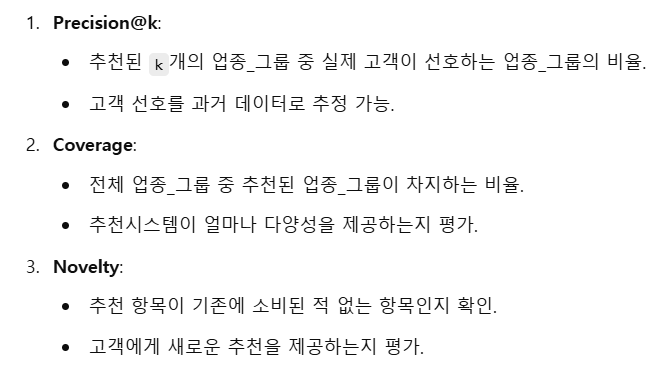\
**2,3만진행**

In [ ]:
def coverage(recommendations, all_items):
    recommended_items = set(item for rec in recommendations for item in rec)
    return len(recommended_items) / len(all_items)

def novelty(recommendations, customer_history):
    novelty_scores = []
    for rec, hist in zip(recommendations, customer_history):
        novel_items = set(rec) - set(hist)
        novelty_scores.append(len(novel_items) / len(rec) if len(rec) > 0 else 0)
    return sum(novelty_scores) / len(novelty_scores)

recommendations = external_df['추천_업종_리스트'].apply(lambda x: x if isinstance(x, list) else []).tolist()

all_items = set(item for sublist in cluster_recommendations.values() for item in sublist)  

customer_history = [[] for _ in range(len(external_df))] 
coverage_score = coverage(recommendations, all_items)

novelty_score = novelty(recommendations, customer_history)

print(f"Coverage: {coverage_score:.2f}")
print(f"Novelty: {novelty_score:.2f}")

In [28]:
def coverage(recommendations, all_items):
    recommended_items = set(item for rec in recommendations for item in rec)
    return len(recommended_items) / len(all_items)

def diversity(recommendations, item_embeddings):
    diversity_scores = []
    for rec in recommendations:
        if len(rec) <= 1:
            continue  
        pairwise_similarities = cosine_similarity(
            [item_embeddings[item] for item in rec if item in item_embeddings]
        )
        avg_similarity = np.mean(pairwise_similarities[np.triu_indices_from(pairwise_similarities, k=1)])
        diversity_scores.append(1 - avg_similarity)
    return np.mean(diversity_scores) if diversity_scores else 0

def novelty(recommendations, customer_history):
    novelty_scores = []
    for rec, hist in zip(recommendations, customer_history):
        novel_items = set(rec) - set(hist)
        novelty_scores.append(len(novel_items) / len(rec) if len(rec) > 0 else 0)
    return sum(novelty_scores) / len(novelty_scores)

def precision_at_k(recommendations, ground_truth, k=10):
    precision_scores = []
    for rec, truth in zip(recommendations, ground_truth):
        top_k = rec[:k]
        hits = len(set(top_k) & set(truth))
        precision_scores.append(hits / k)
    return np.mean(precision_scores)

recommendations = external_sample['최종_추천_리스트'].tolist()
all_items = set(item for sublist in cluster_recommendations.values() for item in sublist)  
customer_history = [[] for _ in range(len(external_sample))]  
ground_truth = [[] for _ in range(len(external_sample))] 

item_embeddings = {item: np.random.rand(10) for item in all_items} 

coverage_score = coverage(recommendations, all_items)
diversity_score = diversity(recommendations, item_embeddings)
novelty_score = novelty(recommendations, customer_history)
precision_score = precision_at_k(recommendations, ground_truth, k=10)

print(f"Coverage: {coverage_score:.2f}")
print(f"Diversity: {diversity_score:.2f}")
print(f"Novelty: {novelty_score:.2f}")
print(f"Precision@10: {precision_score:.2f}")

Coverage: 0.81
Diversity: 0.23
Novelty: 1.00
Precision@10: 0.00
